In [1]:
#packages import
import os
os.chdir('..') #cd to PiperNET folder

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from src.rnaseq_utils import *

#matplotlib settings
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

#config file path
config_path = Path('config/rnaseq_dataprep.yaml')

In [2]:
### Data import ###

#proteomes
proteome_list = get_config(config_path, data='proteome_csv')

for sample, path in proteome_list.items(): 
    proteome_list[sample] = pd.read_csv(path, index_col='id') #update proteome_list with dfs

#unique df with all proteomes
proteomes_all = pd.DataFrame()
for sample, proteome in proteome_list.items(): #iterate over each proteome in proteome_list
    proteome['sample'] = sample #add 'sample' column with sample name (e.g., piper09)
    proteome.columns = [col.split('_', 1)[1] if 'rep' in col else col for col in proteome.columns] #remove sample name from tpm cols
    proteomes_all = pd.concat([proteomes_all, proteome]) #concat df


#sonicparanoid
sonicpd_path = get_config(config_path, data='various', file='sonicparanoid')
sonicpd = import_sonicpd(sonicpd_path)

#blastDB paths
blastDB_paths = get_config(config_path, data='blastDB')

#sequences paths
seq_paths = get_config(config_path, data='enzymeDB')

#prefixes
prefixes = get_config(config_path, data='prefix', filepaths=False)

#species_names
species_names = get_config(config_path, data='species', filepaths=False)

#colors legeng
legend = get_config(config_path, data='colors', filepaths=False)

# Phylogenetic tree on known PKS sequences

In [3]:
#retrieve PKS sequences from enzymeDB
enzymeDB = pd.read_csv('data/rna-seq/enzymeDB.csv')
pksDB = enzymeDB[enzymeDB['Class'] == 'PKS'] #keep only PKS
seq_paths = {k: v for k, v in seq_paths.items() if k in pksDB['Enzyme'].values}

#combine sequences into unique FASTA file
output_file = Path('results/phylogenetic_trees/pks/pksDB.pep')
seqs = []
for enzyme, path in seq_paths.items():
    # Parse the FASTA file
    for record in SeqIO.parse(path, "fasta"):
        # Append the sequence to the list
        seqs.append(record)

SeqIO.write(seqs, output_file, "fasta")

#multiple sequence alignment (MAFFT)
input_file = output_file
output_file = input_file.with_name('pksDB_msa.fasta')

if not os.path.isfile(output_file):
    !mafft --auto {input_file} > {output_file}
else:
    print(f"File {output_file} already exists.")

File results/phylogenetic_trees/pks/pksDB_msa.fasta already exists.


# PKS candidates based on BLAST 
Characterized PKS sequences (from enzymeDB.csv) are BLASTed against all transcriptomes.

To-do:
- BLAST all PKS in enzymeDB - Done
- Remove duplicates ??
- Plot sequence length distribution of hits
- Phylogenetic tree on hits (same query, different samples)

In [4]:
#retrieve PKS sequences from enzymeDB
enzymeDB = pd.read_csv('data/rna-seq/enzymeDB.csv')
pks_seqs = enzymeDB[enzymeDB['Class'] == 'PKS'] #keep all PKS

#BLASTp all seqs vs all proteomes
output_file = Path('results//blast/pks_hits.csv')

if not os.path.isfile(output_file):

    seq_paths = {k: v for k, v in seq_paths.items() if k in pks_seqs['Enzyme'].values}
    hits_all = run_blastp(seq_paths, blastDB_paths, min_cov=50, min_sim=50)

    #save results as CSV 
    hits_all.to_csv(output_file, index=False)

else:
    print(f"File {output_file} already exists. Importing existing file.")
    hits_all = pd.read_csv(output_file) #import existing file


#create sample column based on hit's prefix
hits_all['sample'] = hits_all['hit'].str.split('_').str[0] + '_'
hits_all['sample'] = hits_all['sample'].map({k: v for v, k in prefixes.items()})

#add enzyme name columns
hits_all = hits_all.merge(pks_seqs[['Name', 'Species', 'Enzyme']], left_on='query', right_on='Enzyme', how='left').drop('Enzyme', axis=1)

File results/blast/pks_hits.csv already exists. Importing existing file.


# Heatmap on n° of retrieved BLASTp hits
- Rows: PKS sequences
- Columns: samples
- Colour intensity: n° hits (or expression levels)

<Figure size 1600x2400 with 0 Axes>

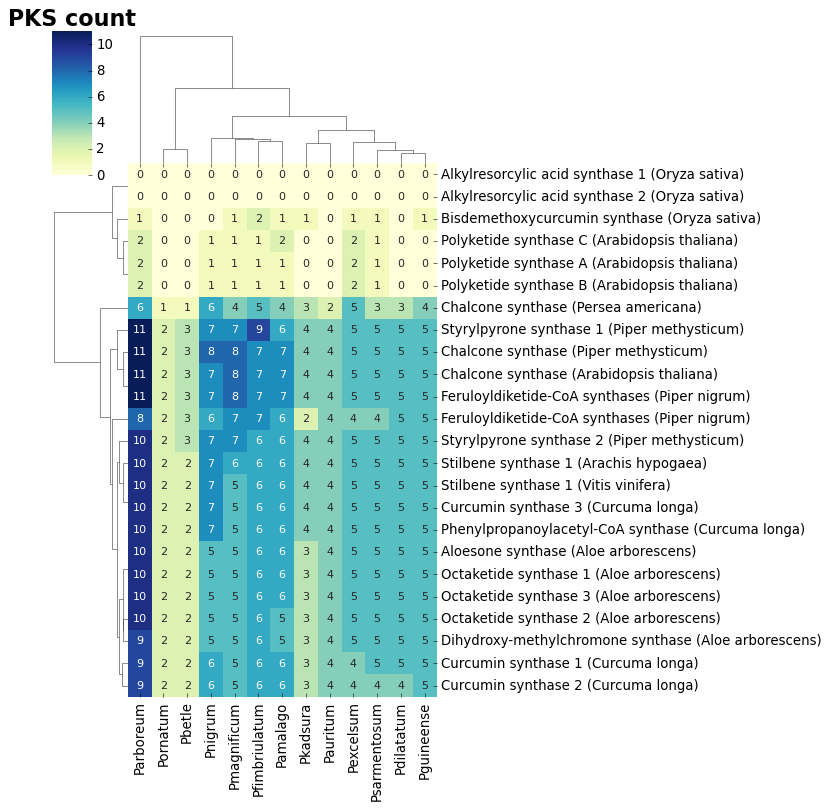

In [8]:
#filter based on min similarity and coverage
hits_filt = hits_all[(hits_all['similarity'] >= 70) & (hits_all['coverage'] >= 50)]

#count hits per sample per each query
hits_count = hits_filt.groupby(['query', 'sample']).size()

#create sequences-vs-sample matrix
matrix = pd.DataFrame(index=seq_paths.keys(), columns=proteome_list.keys())

#fill each entry with n° of BLAST hits
for enzyme in matrix.index:
    for sample in matrix.columns:
        if (enzyme, sample) in hits_count.index:
            matrix.at[enzyme, sample] = hits_count[enzyme][sample]
        else:
            matrix.at[enzyme, sample] = 0


#rename matrix indexes with enzyme names
# seq_names = hits_filt.set_index('query')['Name'].to_dict() #dict mapping query names to enzyme names
seq_names = hits_all.set_index('query')[['Name', 'Species']].apply(lambda x: f"{x[0]} ({x[1]})", axis=1).to_dict() #dict mapping query names to enzyme names
matrix.index = [seq_names.get(idx, idx) for idx in matrix.index]


#plot
matrix.rename(columns=species_names, inplace=True)
plt.figure(figsize=(20, 30))
# sns.heatmap(matrix.astype(float), annot=True, cmap='YlGnBu')
sns.clustermap(matrix.astype(float), cmap='YlGnBu', annot=True, fmt='g', annot_kws={"fontsize": 10})
plt.title('PKS count', fontsize=20, fontweight='bold')
plt.show()

#TODO:sort rows by phylogenetic tree of PKS sequences

In [12]:
hits_filt
hits_all['sample'].value_counts()
# for enzyme in matrix.index:
#     for sample in matrix.columns:
#         print(enzyme, sample)

piper23    300
piper10    216
piper09    195
piper25    191
piper56    178
piper55    167
piper26    143
piper12    120
piper54     96
piper27     94
piper20     72
piper06     48
Name: sample, dtype: int64

In [107]:
#filter based on min similarity and coverage
hits_filt = hits_all[(hits_all['similarity'] >= 80) & (hits_all['coverage'] >= 70)]
hits_best = hits_filt.groupby('hit', as_index=False).apply(lambda x: x.sort_values('similarity', ascending=False).head(1)).reset_index(drop=True)

#Filter rows in sonicpd where any element in hits_best['hit'] is in sonicpd[sample_cols]
sample_cols = [col for col in sonicpd.columns if 'piper' in col]
mask = sonicpd[sample_cols].applymap(lambda lst: any(elem in hits_best['hit'].values for elem in lst)).any(axis=1)
pks_orths = sonicpd[mask]
pks_orths

,group_size,sp_in_grp,seed_ortholog_cnt,piper06,piper09,piper10,piper12,piper20,piper23,piper25,piper26,piper27,piper32,piper54,piper55,piper56
group_id,,,,,,,,,,,,,,,,
16783,15,13,15,[Porn_g23680_i0.p1],[Pfim_g9212_i1.p1],[Pmag_g37537_i0.p1],[Pdil_g13033_i1.p1],[Pbet_g16475_i0.p1],"[Parb_g12475_i1.p1, Parb_g32725_i0.p1, Parb_g3...",[Pama_g17209_i1.p1],[Psar_g184_i58.p1],[Pkad_g18571_i0.p1],[Pgui_g17154_i0.p1],[Paur_g11503_i1.p1],[Pexc_g25292_i0.p1],[Pnig_g16384_i0.p1]
19141,14,13,14,[Porn_g15459_i1.p1],[Pfim_g13608_i1.p1],[Pmag_g27854_i0.p1],[Pdil_g16718_i2.p1],[Pbet_g18249_i2.p1],[Parb_g14045_i2.p1],[Pama_g24981_i1.p1],[Psar_g25232_i0.p1],[Pkad_g23510_i0.p1],[Pgui_g15351_i1.p1],[Paur_g16197_i1.p1],[Pexc_g12730_i1.p1],"[Pnig_g909_i25.p1, Pnig_g8672_i1.p1]"
26184,12,9,12,[],[Pfim_g17426_i0.p1],[Pmag_g11660_i0.p1],[],[],"[Parb_g16041_i2.p1, Parb_g16041_i4.p1]","[Pama_g59677_i0.p1, Pama_g62379_i0.p1]",[Psar_g9900_i0.p2],[],[Pgui_g112978_i0.p1],[Paur_g49590_i0.p1],"[Pexc_g3772_i3.p1, Pexc_g3772_i0.p2]",[Pnig_g44643_i0.p1]
38523,8,8,8,[],[],[Pmag_g1428_i4.p1],[],[],[Parb_g24578_i0.p1],[Pama_g20295_i1.p1],[Psar_g28415_i1.p1],[],[Pgui_g21625_i0.p1],[Paur_g19181_i0.p1],[Pexc_g14782_i0.p1],[Pnig_g8933_i0.p1]
45986,6,5,6,[Porn_g15459_i0.p1],[],[],[],[],[],[],[Psar_g25232_i2.p1],[],[Pgui_g15351_i0.p1],[],[Pexc_g12730_i0.p2],"[Pnig_g909_i20.p1, Pnig_g909_i22.p1]"
48012,6,6,6,[],[Pfim_g20510_i0.p1],[Pmag_g31471_i0.p1],[Pdil_g17712_i1.p1],[],[Parb_g7882_i12.p1],[],[],[],[Pgui_g30094_i0.p1],[Paur_g17997_i0.p1],[],[]
67063,4,4,4,[],[Pfim_g19753_i0.p1],[Pmag_g28393_i0.p1],[],[],[Parb_g30367_i0.p1],[Pama_g34420_i0.p1],[],[],[],[],[],[]
